# Problem setting: Sine Wave Prediction.

This jupyter notebook demonstrates that the function of pre-learning with **LSTM-RTRBM** (Long Short-Term Memory Reccurent Temporal Restricted Boltzmann Machine) is to improve performance of learning with single LSTM. On the context of paradigm of Deep learning and *Transfer learning*, the initialization strategies, based on not only a mere Gaussian noise but also unsupervised pre-learning of each layer, have been shown to be important both for supervised and unsupervised learning of Machine learning. In particular, LSTM-RTRBM makes it possible to do pre-learning and Transfer learning for probabilistic time series patterns.

It can be easy to implement a comparison of initialization strategies by introducing simple toy problem, namely Sine Wave Prediction. The required function of Machine learning solving this problem is to predict unknown future values in a time series by observing data points of Sine waves.

In this demonstration, the training dataset is generated as follows.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The number of sampled data.
sample_n = 1000
# The length of one cycle.
cycle_len = 100
# Amplitude of Sine Wave.
amp = 0.05
# The rate of the length of predicted data.
target_size = 0.5

# The list of observed data points.
observed_arr_list = []
# The list of objective data.
target_arr_list = []

for _ in range(sample_n):
    sin_arr = np.sin(2.0 * np.pi * np.arange(0, cycle_len))
    noise_arr = amp * np.random.normal(loc=0.0, scale=0.5, size=sin_arr.shape[0])
    sin_arr += noise_arr

    observed_arr_list.append(sin_arr[:int(sin_arr.shape[0] * (1 - target_size))])
    target_arr_list.append(sin_arr[int(sin_arr.shape[0] * (1 - target_size)):])

# Reshape for `LSTMModel`.
observed_arr = np.array(observed_arr_list)
observed_arr = observed_arr.reshape(observed_arr.shape[0], observed_arr.shape[1], 1)
target_arr = np.array(target_arr_list)

All Sine waves have been added randomly generated gussain signal noise.

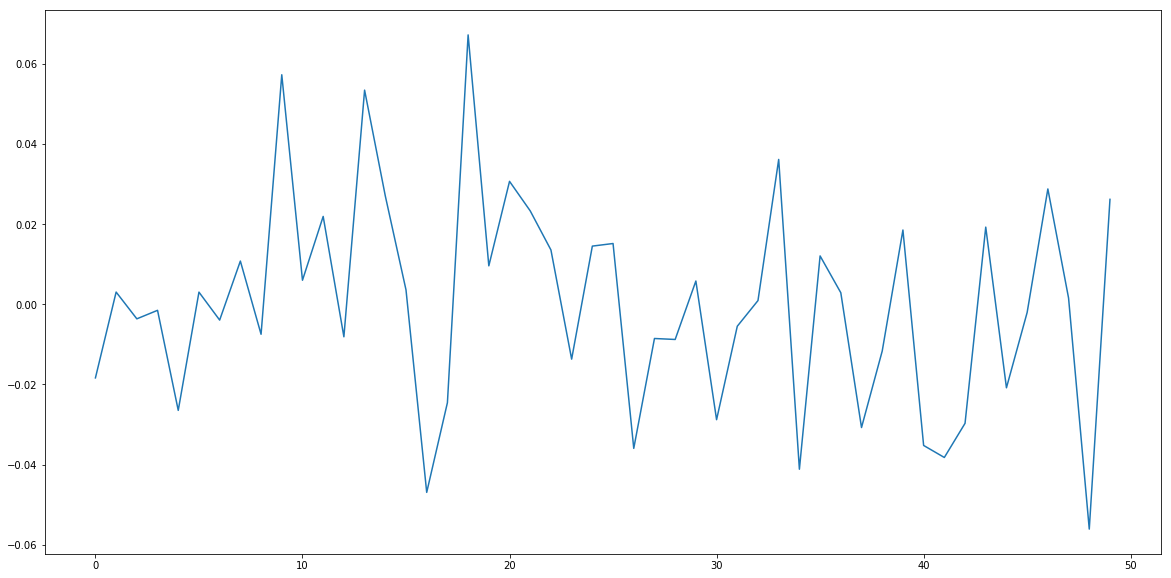

In [3]:
fig = plt.figure(figsize=(20, 10))
plt.plot(observed_arr[0][:][:])
plt.show();plt.close()

## Problem solution: Standard LSTM (without LSTM-RTRBM).

First of all, let us execute learning not based on pre-learned parameters in order to compare initialization strategies.

### Hyperparameters and loss function.

We will verificate the accuracy of LSTM, learning same Sine wave dataset, with-and-without LSTM-RTRBM under the same conditions, where...

- `hidden_neuron_count` is `100`, 
- `epochs` is `300`,
- `batch_size` is `20`,
- `learning_rate` is `1e-05`,
- `learning_attenuate_rate` is `0.1`, 
- `attenuate_epoch` is `50`, 
- `test_size_rate` is `0.3`, 

and logging the loss function: Mean Square Error(MSE).

In [4]:
# LSTM Graph which is-a `Synapse`.
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph
# Cost function for logging and verification.
from pydbm.rnn.loss.mean_squared_error import MeanSquaredError
# Verification.
from pydbm.rnn.verification.verificate_function_approximation import VerificateFunctionApproximation
# LSTM model.
from pydbm.rnn.lstm_model import LSTMModel
# Logistic Function as activation function.
from pydbm.activation.logistic_function import LogisticFunction
# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction

In [5]:
# Init.
graph = LSTMGraph()

# Activation function in LSTM.
graph.observed_activating_function = TanhFunction()
graph.input_gate_activating_function = LogisticFunction()
graph.forget_gate_activating_function = LogisticFunction()
graph.output_gate_activating_function = LogisticFunction()
graph.hidden_activating_function = TanhFunction()
graph.output_activating_function = LogisticFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
graph.create_rnn_cells(
    input_neuron_count=observed_arr.shape[-1],
    hidden_neuron_count=100,
    output_neuron_count=target_arr.shape[-1]
)

In [6]:
lstm_model = LSTMModel(
    # Delegate `graph` to `LSTMModel`.
    graph=graph,
    # The number of epochs in mini-batch training.
    epochs=150,
    # The batch size.
    batch_size=20,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # Regularization for weights matrix in hidden layer(RNN layers)
    # to repeat multiplying the weights matrix and `0.9` until
    # $\sum_{j=0}^{n}w_{ji}^2 < weight\_limit$.
    weight_limit=0.5,
    # The probability of dropout.
    dropout_rate=0.5,
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=16,
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(MeanSquaredError())
)

In [7]:
# Learning.
lstm_model.learn(observed_arr, target_arr)

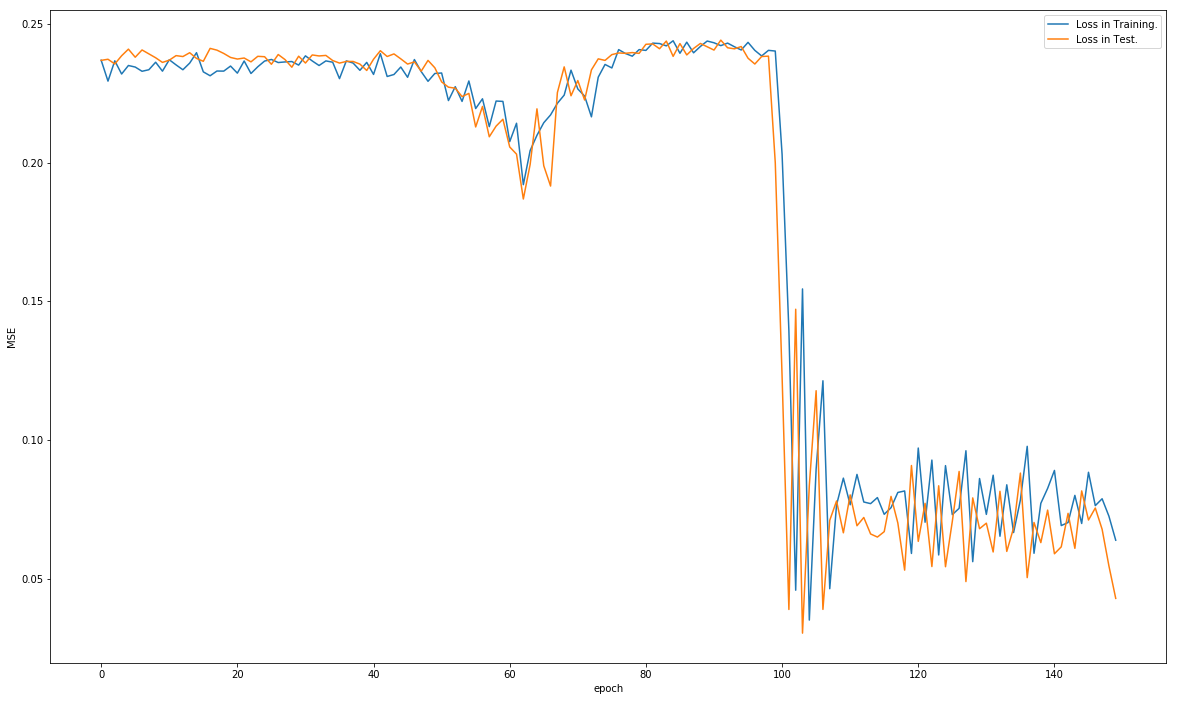

In [19]:
# Logging the loss.
fig = plt.figure(figsize=(20, 12))
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.plot(lstm_model.verificatable_result.logs_df.train_loss.values[:150], label="Loss in Training.")
plt.plot(lstm_model.verificatable_result.logs_df.test_loss.values[:150], label="Loss in Test.")
plt.legend()
plt.show();plt.close()

In [9]:
lstm_model.verificatable_result.logs_df.tail(10)

,train_loss,test_loss
140,0.089023,0.058987
141,0.069148,0.061471
142,0.070239,0.073551
143,0.080033,0.060942
144,0.069900,0.081638
145,0.088359,0.071148
146,0.076332,0.075473
147,0.078814,0.067829
148,0.072532,0.054609
149,0.063873,0.042902


## Functional equivalent: LSTM with LSTM-RTRBM.

Then, we attempt to comparison between functional equivalents: combination LSTM with LSTM-RTRBM.

### Hyperparameters and loss function.

- `hidden_neuron_count` is `100`, 
- `epochs` is `300`,
- `batch_size` is `20`,
- `learning_rate` is `1e-05`,
- `learning_attenuate_rate` is `0.1`, 
- `attenuate_epoch` is `50`, 
- `test_size_rate` is `0.3`, 
- LSTM-RTRBM's `training_count` is `100`,

and logging the loss function: Mean Square Error(MSE).

In [10]:
# `Builder` in `Builder Patter`.
from pydbm.dbm.builders.lstm_rt_rbm_simple_builder import LSTMRTRBMSimpleBuilder
# LSTM and Contrastive Divergence for function approximation.
from pydbm.approximation.rtrbmcd.lstm_rt_rbm_cd import LSTMRTRBMCD

In [11]:
# `Builder` in `Builder Pattern` for LSTM-RTRBM.
rnnrbm_builder = LSTMRTRBMSimpleBuilder()
# Learning rate.
rnnrbm_builder.learning_rate = 1e-05
# Set units in visible layer.
rnnrbm_builder.visible_neuron_part(LogisticFunction(), observed_arr.shape[-1])
# Set units in hidden layer.
rnnrbm_builder.hidden_neuron_part(LogisticFunction(), 100)
# Set units in RNN layer.
rnnrbm_builder.rnn_neuron_part(TanhFunction())
# Set graph and approximation function.
rnnrbm_builder.graph_part(LSTMRTRBMCD())
# Building.
rbm = rnnrbm_builder.get_result()

In [12]:
# Learning.
rbm.learn(
    observed_arr,
    training_count=1, 
    batch_size=20
)

In [13]:
graph = rbm.extract_transfered_params(
    input_neuron_count=observed_arr.shape[-1],
    hidden_neuron_count=100,
    output_neuron_count=target_arr.shape[-1]
)

In [14]:
# LSTM model.
from pydbm.rnn.lstm_model import LSTMModel

lstm_model2 = LSTMModel(
    # Delegate `graph` to `LSTMModel`.
    graph=graph,
    # The number of epochs in mini-batch training.
    epochs=150,
    # The batch size.
    batch_size=20,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # Regularization for weights matrix in hidden layer(RNN layers)
    # to repeat multiplying the weights matrix and `0.9` until
    # $\sum_{j=0}^{n}w_{ji}^2 < weight\_limit$.
    weight_limit=0.0,
    # The probability of dropout.
    dropout_rate=0.0,
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=16,
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(MeanSquaredError())
)

In [15]:
# Learning.
lstm_model2.learn(observed_arr, target_arr)

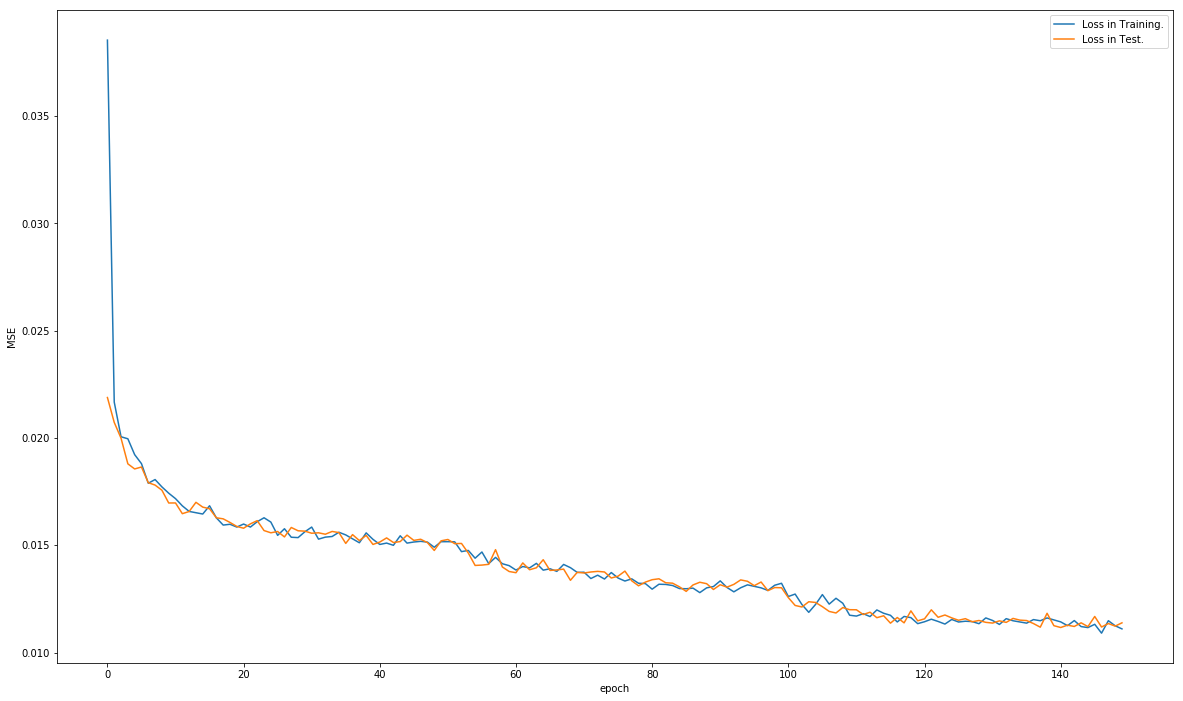

In [20]:
# Logging the loss.
fig = plt.figure(figsize=(20, 12))
plt.ylabel("MSE")
plt.xlabel("epoch")
plt.plot(lstm_model2.verificatable_result.logs_df.train_loss.values, label="Loss in Training.")
plt.plot(lstm_model2.verificatable_result.logs_df.test_loss.values, label="Loss in Test.")
plt.legend()
plt.show();plt.close()

In [17]:
lstm_model2.verificatable_result.logs_df.tail(10)

,train_loss,test_loss
140,0.011428,0.011165
141,0.011252,0.011274
142,0.011489,0.011214
143,0.011209,0.011384
144,0.011161,0.011207
145,0.011315,0.011679
146,0.010902,0.011188
147,0.011483,0.011351
148,0.011247,0.011230
149,0.011100,0.011383


The difference of MSE observed from the simple toy problem demonstrates that the function of LSTM-RTRBM's pre-learning is to improve performance of LSTM's learning. 

# References.

- Boulanger-Lewandowski, N., Bengio, Y., & Vincent, P. (2012). Modeling temporal dependencies in high-dimensional sequences: Application to polyphonic music generation and transcription. arXiv preprint arXiv:1206.6392.
- Lyu, Q., Wu, Z., Zhu, J., & Meng, H. (2015, June). Modelling High-Dimensional Sequences with LSTM-RTRBM: Application to Polyphonic Music Generation. In IJCAI (pp. 4138-4139).
- Lyu, Q., Wu, Z., & Zhu, J. (2015, October). Polyphonic music modelling with LSTM-RTRBM. In Proceedings of the 23rd ACM international conference on Multimedia (pp. 991-994). ACM.
- Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The Journal of Machine Learning Research, 15(1), 1929-1958.
- Sutskever, I., Hinton, G. E., & Taylor, G. W. (2009). The recurrent temporal restricted boltzmann machine. In Advances in Neural Information Processing Systems (pp. 1601-1608).

## Related PoC

- [深層強化学習のベイズ主義的な情報探索に駆動された自然言語処理の意味論](https://accel-brain.com/semantics-of-natural-language-processing-driven-by-bayesian-information-search-by-deep-reinforcement-learning/) (Japanese)